In [1]:
import random 
import os
import sys 

In [2]:
import numpy as np 
import cv2
import json 
from pathlib import Path
import matplotlib.pyplot as plt 

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog,MetadataCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

### Registor dataset

In [5]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
train_json_path = os.path.join(data_dir, 'trainFix.json')
validation_json_path = os.path.join(data_dir, 'validationFix.json')

In [6]:
train_data_name = 'fashion_train'
val_data_name = 'fashion_val'


register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train') )
register_coco_instances(val_data_name, {}, validation_json_path, os.path.join(data_dir, 'train') )

### Visualize train dataset
* to verify the data loading is correct 

[06/03 12:30:48 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/trainFix.json takes 15.44 seconds.
WARNING [06/03 12:30:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/03 12:30:50 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/trainFix.json
Path: ../imaterialist-fashion-2020-fgvc7/train/e8c9e8da29a18926373c970b19fd25d9.jpg
(1500, 1000, 3)
Height:  1500
Width:  1000


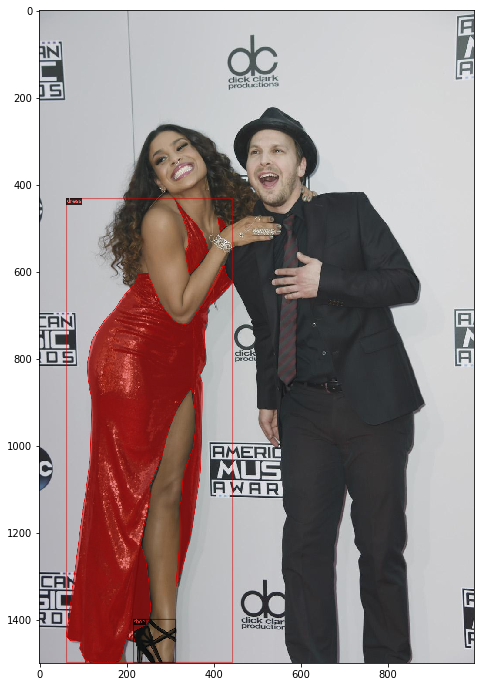

Path: ../imaterialist-fashion-2020-fgvc7/train/cdb0e4bf6e13c3c940d8e0c844ef0ae4.jpg
(3456, 4100, 3)
Height:  3456
Width:  4100


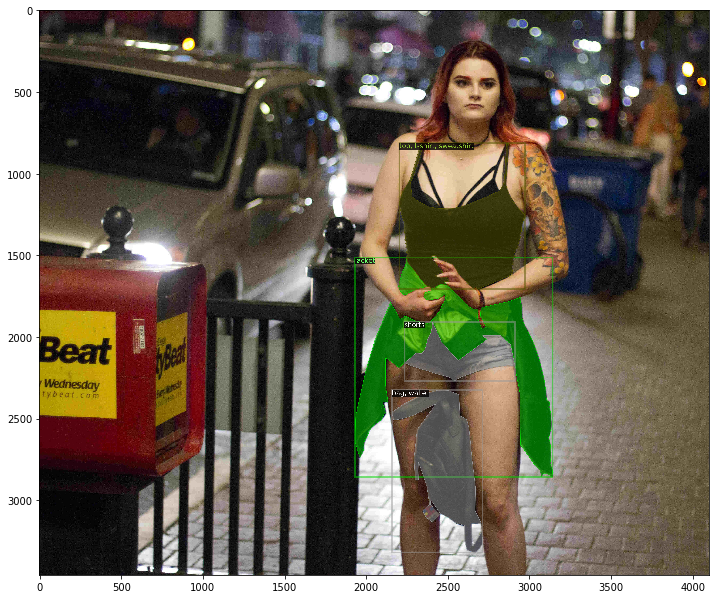

Path: ../imaterialist-fashion-2020-fgvc7/train/9806d62bcec0982f46c166a3648444ee.jpg
(3000, 1997, 3)
Height:  3000
Width:  1997


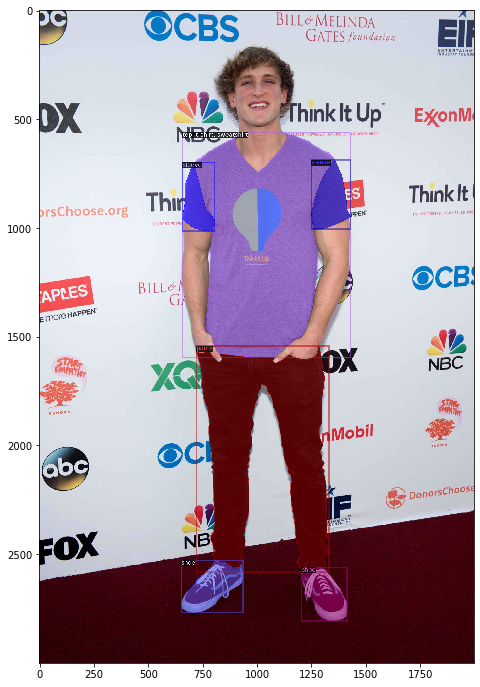

In [7]:
train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    print("Path:",d["file_name"] )
    print(img.shape)
    print("Height: ",d["height"] )
    print("Width: ", d["width"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Set Config and Import model files 

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_data_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # only has one class (ballon)

## Training 

In [9]:
# update create ouptput directory 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [10]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

[06/03 12:30:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/03 12:31:14 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/trainFix.json takes 17.35 seconds.
WARNING [06/03 12:31:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/03 12:31:14 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/trainFix.json
[06/03 12:31:17 d2.data.build]: Removed 0 images with no usable annotations. 41060 images left.
[06/03 12:31:18 d2.data.build]: Distribution of instances among all 46 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| shirt, blouse | 5535         | top, t-shir.. | 14897        |  sweater   | 1341         |
|   cardigan    | 987          |    jacket     | 7027         |    vest    | 652          |
|     pants     | 11152        |    shorts     | 2504         |   sk

In [11]:
# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (47, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (47,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (184, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (184,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (46, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (46,) in the model! Skipped.


In [12]:
# start training
trainer.train()

[06/03 12:31:23 d2.engine.train_loop]: Starting training from iteration 0
[06/03 12:31:30 d2.utils.events]:  eta: 0:47:02  iter: 19  total_loss: 5.818  loss_cls: 3.943  loss_box_reg: 0.790  loss_mask: 0.692  loss_rpn_cls: 0.315  loss_rpn_loc: 0.056  time: 0.3415  data_time: 0.1200  lr: 0.000005  max_mem: 2582M
[06/03 12:31:36 d2.utils.events]:  eta: 0:45:49  iter: 39  total_loss: 5.663  loss_cls: 3.820  loss_box_reg: 0.771  loss_mask: 0.692  loss_rpn_cls: 0.303  loss_rpn_loc: 0.070  time: 0.3215  data_time: 0.0539  lr: 0.000010  max_mem: 2582M
[06/03 12:31:42 d2.utils.events]:  eta: 0:45:43  iter: 59  total_loss: 5.271  loss_cls: 3.544  loss_box_reg: 0.772  loss_mask: 0.692  loss_rpn_cls: 0.214  loss_rpn_loc: 0.057  time: 0.3145  data_time: 0.0579  lr: 0.000015  max_mem: 2709M
[06/03 12:31:49 d2.utils.events]:  eta: 0:45:46  iter: 79  total_loss: 4.895  loss_cls: 3.186  loss_box_reg: 0.752  loss_mask: 0.690  loss_rpn_cls: 0.240  loss_rpn_loc: 0.056  time: 0.3154  data_time: 0.0861  lr:

[06/03 12:34:52 d2.utils.events]:  eta: 0:43:30  iter: 679  total_loss: 1.750  loss_cls: 0.625  loss_box_reg: 0.702  loss_mask: 0.376  loss_rpn_cls: 0.045  loss_rpn_loc: 0.052  time: 0.3058  data_time: 0.0187  lr: 0.000170  max_mem: 2767M
[06/03 12:34:58 d2.utils.events]:  eta: 0:43:24  iter: 699  total_loss: 1.871  loss_cls: 0.614  loss_box_reg: 0.683  loss_mask: 0.382  loss_rpn_cls: 0.049  loss_rpn_loc: 0.040  time: 0.3056  data_time: 0.0625  lr: 0.000175  max_mem: 2767M
[06/03 12:35:04 d2.utils.events]:  eta: 0:43:18  iter: 719  total_loss: 1.517  loss_cls: 0.527  loss_box_reg: 0.610  loss_mask: 0.312  loss_rpn_cls: 0.029  loss_rpn_loc: 0.041  time: 0.3051  data_time: 0.0523  lr: 0.000180  max_mem: 2767M
[06/03 12:35:10 d2.utils.events]:  eta: 0:43:13  iter: 739  total_loss: 1.536  loss_cls: 0.500  loss_box_reg: 0.610  loss_mask: 0.347  loss_rpn_cls: 0.035  loss_rpn_loc: 0.045  time: 0.3049  data_time: 0.0520  lr: 0.000185  max_mem: 2767M
[06/03 12:35:15 d2.utils.events]:  eta: 0:43

[06/03 12:38:14 d2.utils.events]:  eta: 0:40:52  iter: 1339  total_loss: 1.192  loss_cls: 0.415  loss_box_reg: 0.446  loss_mask: 0.265  loss_rpn_cls: 0.023  loss_rpn_loc: 0.029  time: 0.3061  data_time: 0.0558  lr: 0.000250  max_mem: 2767M
[06/03 12:38:22 d2.utils.events]:  eta: 0:40:47  iter: 1359  total_loss: 1.382  loss_cls: 0.519  loss_box_reg: 0.475  loss_mask: 0.262  loss_rpn_cls: 0.021  loss_rpn_loc: 0.042  time: 0.3069  data_time: 0.1229  lr: 0.000250  max_mem: 2767M
[06/03 12:38:28 d2.utils.events]:  eta: 0:40:42  iter: 1379  total_loss: 1.444  loss_cls: 0.518  loss_box_reg: 0.551  loss_mask: 0.293  loss_rpn_cls: 0.039  loss_rpn_loc: 0.033  time: 0.3067  data_time: 0.0485  lr: 0.000250  max_mem: 2767M
[06/03 12:38:34 d2.utils.events]:  eta: 0:40:38  iter: 1399  total_loss: 1.324  loss_cls: 0.428  loss_box_reg: 0.524  loss_mask: 0.290  loss_rpn_cls: 0.029  loss_rpn_loc: 0.043  time: 0.3066  data_time: 0.0318  lr: 0.000250  max_mem: 2767M
[06/03 12:38:40 d2.utils.events]:  eta: 

[06/03 12:41:40 d2.utils.events]:  eta: 0:38:13  iter: 1999  total_loss: 1.112  loss_cls: 0.359  loss_box_reg: 0.456  loss_mask: 0.286  loss_rpn_cls: 0.025  loss_rpn_loc: 0.029  time: 0.3077  data_time: 0.0319  lr: 0.000250  max_mem: 2767M
[06/03 12:41:46 d2.utils.events]:  eta: 0:38:07  iter: 2019  total_loss: 1.105  loss_cls: 0.302  loss_box_reg: 0.461  loss_mask: 0.259  loss_rpn_cls: 0.026  loss_rpn_loc: 0.030  time: 0.3079  data_time: 0.0511  lr: 0.000250  max_mem: 2767M
[06/03 12:41:52 d2.utils.events]:  eta: 0:38:03  iter: 2039  total_loss: 1.195  loss_cls: 0.326  loss_box_reg: 0.441  loss_mask: 0.272  loss_rpn_cls: 0.030  loss_rpn_loc: 0.035  time: 0.3077  data_time: 0.0404  lr: 0.000250  max_mem: 2767M
[06/03 12:41:59 d2.utils.events]:  eta: 0:37:57  iter: 2059  total_loss: 1.067  loss_cls: 0.333  loss_box_reg: 0.439  loss_mask: 0.249  loss_rpn_cls: 0.025  loss_rpn_loc: 0.030  time: 0.3080  data_time: 0.0862  lr: 0.000250  max_mem: 2767M
[06/03 12:42:06 d2.utils.events]:  eta: 

[06/03 12:45:10 d2.utils.events]:  eta: 0:35:09  iter: 2659  total_loss: 1.104  loss_cls: 0.335  loss_box_reg: 0.412  loss_mask: 0.260  loss_rpn_cls: 0.028  loss_rpn_loc: 0.034  time: 0.3103  data_time: 0.0494  lr: 0.000250  max_mem: 2767M
[06/03 12:45:18 d2.utils.events]:  eta: 0:35:06  iter: 2679  total_loss: 1.122  loss_cls: 0.356  loss_box_reg: 0.421  loss_mask: 0.230  loss_rpn_cls: 0.018  loss_rpn_loc: 0.031  time: 0.3107  data_time: 0.1089  lr: 0.000250  max_mem: 2767M
[06/03 12:45:24 d2.utils.events]:  eta: 0:34:59  iter: 2699  total_loss: 1.294  loss_cls: 0.403  loss_box_reg: 0.466  loss_mask: 0.243  loss_rpn_cls: 0.021  loss_rpn_loc: 0.040  time: 0.3108  data_time: 0.0899  lr: 0.000250  max_mem: 2767M
[06/03 12:45:30 d2.utils.events]:  eta: 0:34:52  iter: 2719  total_loss: 1.159  loss_cls: 0.345  loss_box_reg: 0.427  loss_mask: 0.253  loss_rpn_cls: 0.024  loss_rpn_loc: 0.036  time: 0.3106  data_time: 0.0512  lr: 0.000250  max_mem: 2767M
[06/03 12:45:37 d2.utils.events]:  eta: 

[06/03 12:48:36 d2.utils.events]:  eta: 0:31:47  iter: 3319  total_loss: 1.121  loss_cls: 0.365  loss_box_reg: 0.407  loss_mask: 0.213  loss_rpn_cls: 0.024  loss_rpn_loc: 0.032  time: 0.3104  data_time: 0.0550  lr: 0.000250  max_mem: 2767M
[06/03 12:48:43 d2.utils.events]:  eta: 0:31:41  iter: 3339  total_loss: 1.115  loss_cls: 0.352  loss_box_reg: 0.420  loss_mask: 0.245  loss_rpn_cls: 0.020  loss_rpn_loc: 0.037  time: 0.3106  data_time: 0.1079  lr: 0.000250  max_mem: 2767M
[06/03 12:48:50 d2.utils.events]:  eta: 0:31:35  iter: 3359  total_loss: 1.226  loss_cls: 0.354  loss_box_reg: 0.406  loss_mask: 0.238  loss_rpn_cls: 0.027  loss_rpn_loc: 0.032  time: 0.3110  data_time: 0.1619  lr: 0.000250  max_mem: 2767M
[06/03 12:48:58 d2.utils.events]:  eta: 0:31:28  iter: 3379  total_loss: 1.230  loss_cls: 0.396  loss_box_reg: 0.441  loss_mask: 0.267  loss_rpn_cls: 0.034  loss_rpn_loc: 0.040  time: 0.3114  data_time: 0.1350  lr: 0.000250  max_mem: 2767M
[06/03 12:49:03 d2.utils.events]:  eta: 

[06/03 12:52:05 d2.utils.events]:  eta: 0:28:37  iter: 3979  total_loss: 0.985  loss_cls: 0.318  loss_box_reg: 0.379  loss_mask: 0.227  loss_rpn_cls: 0.023  loss_rpn_loc: 0.030  time: 0.3113  data_time: 0.0207  lr: 0.000250  max_mem: 2767M
[06/03 12:52:11 d2.utils.events]:  eta: 0:28:34  iter: 3999  total_loss: 1.015  loss_cls: 0.345  loss_box_reg: 0.394  loss_mask: 0.226  loss_rpn_cls: 0.028  loss_rpn_loc: 0.035  time: 0.3113  data_time: 0.0773  lr: 0.000250  max_mem: 2767M
[06/03 12:52:18 d2.utils.events]:  eta: 0:28:28  iter: 4019  total_loss: 0.927  loss_cls: 0.293  loss_box_reg: 0.326  loss_mask: 0.226  loss_rpn_cls: 0.022  loss_rpn_loc: 0.029  time: 0.3114  data_time: 0.0982  lr: 0.000250  max_mem: 2767M
[06/03 12:52:23 d2.utils.events]:  eta: 0:28:20  iter: 4039  total_loss: 0.895  loss_cls: 0.231  loss_box_reg: 0.381  loss_mask: 0.221  loss_rpn_cls: 0.020  loss_rpn_loc: 0.024  time: 0.3113  data_time: 0.0160  lr: 0.000250  max_mem: 2767M
[06/03 12:52:30 d2.utils.events]:  eta: 

[06/03 12:55:25 d2.utils.events]:  eta: 0:25:20  iter: 4639  total_loss: 1.167  loss_cls: 0.392  loss_box_reg: 0.423  loss_mask: 0.262  loss_rpn_cls: 0.030  loss_rpn_loc: 0.028  time: 0.3101  data_time: 0.0480  lr: 0.000250  max_mem: 2767M
[06/03 12:55:31 d2.utils.events]:  eta: 0:25:12  iter: 4659  total_loss: 1.001  loss_cls: 0.287  loss_box_reg: 0.379  loss_mask: 0.216  loss_rpn_cls: 0.021  loss_rpn_loc: 0.038  time: 0.3100  data_time: 0.0413  lr: 0.000250  max_mem: 2767M
[06/03 12:55:37 d2.utils.events]:  eta: 0:25:05  iter: 4679  total_loss: 1.108  loss_cls: 0.349  loss_box_reg: 0.408  loss_mask: 0.218  loss_rpn_cls: 0.026  loss_rpn_loc: 0.037  time: 0.3101  data_time: 0.0771  lr: 0.000250  max_mem: 2767M
[06/03 12:55:44 d2.utils.events]:  eta: 0:25:01  iter: 4699  total_loss: 1.047  loss_cls: 0.353  loss_box_reg: 0.380  loss_mask: 0.220  loss_rpn_cls: 0.026  loss_rpn_loc: 0.038  time: 0.3101  data_time: 0.0607  lr: 0.000250  max_mem: 2767M
[06/03 12:55:49 d2.utils.events]:  eta: 

[06/03 12:58:48 d2.utils.events]:  eta: 0:22:09  iter: 5299  total_loss: 0.920  loss_cls: 0.269  loss_box_reg: 0.353  loss_mask: 0.206  loss_rpn_cls: 0.023  loss_rpn_loc: 0.034  time: 0.3095  data_time: 0.0585  lr: 0.000250  max_mem: 2767M
[06/03 12:58:56 d2.utils.events]:  eta: 0:22:03  iter: 5319  total_loss: 0.945  loss_cls: 0.237  loss_box_reg: 0.379  loss_mask: 0.205  loss_rpn_cls: 0.023  loss_rpn_loc: 0.029  time: 0.3098  data_time: 0.1744  lr: 0.000250  max_mem: 2767M
[06/03 12:59:03 d2.utils.events]:  eta: 0:21:59  iter: 5339  total_loss: 1.082  loss_cls: 0.331  loss_box_reg: 0.377  loss_mask: 0.244  loss_rpn_cls: 0.027  loss_rpn_loc: 0.047  time: 0.3099  data_time: 0.0853  lr: 0.000250  max_mem: 2767M
[06/03 12:59:09 d2.utils.events]:  eta: 0:21:55  iter: 5359  total_loss: 0.791  loss_cls: 0.204  loss_box_reg: 0.355  loss_mask: 0.199  loss_rpn_cls: 0.018  loss_rpn_loc: 0.034  time: 0.3100  data_time: 0.0678  lr: 0.000250  max_mem: 2767M
[06/03 12:59:15 d2.utils.events]:  eta: 

[06/03 13:02:14 d2.utils.events]:  eta: 0:19:07  iter: 5959  total_loss: 0.974  loss_cls: 0.285  loss_box_reg: 0.373  loss_mask: 0.213  loss_rpn_cls: 0.020  loss_rpn_loc: 0.030  time: 0.3098  data_time: 0.0448  lr: 0.000250  max_mem: 2767M
[06/03 13:02:21 d2.utils.events]:  eta: 0:19:02  iter: 5979  total_loss: 0.997  loss_cls: 0.289  loss_box_reg: 0.345  loss_mask: 0.205  loss_rpn_cls: 0.016  loss_rpn_loc: 0.026  time: 0.3099  data_time: 0.1088  lr: 0.000250  max_mem: 2767M
[06/03 13:02:27 d2.utils.events]:  eta: 0:18:57  iter: 5999  total_loss: 0.951  loss_cls: 0.287  loss_box_reg: 0.346  loss_mask: 0.211  loss_rpn_cls: 0.017  loss_rpn_loc: 0.037  time: 0.3099  data_time: 0.0517  lr: 0.000250  max_mem: 2767M
[06/03 13:02:33 d2.utils.events]:  eta: 0:18:52  iter: 6019  total_loss: 1.118  loss_cls: 0.359  loss_box_reg: 0.395  loss_mask: 0.219  loss_rpn_cls: 0.025  loss_rpn_loc: 0.030  time: 0.3099  data_time: 0.0443  lr: 0.000250  max_mem: 2767M
[06/03 13:02:40 d2.utils.events]:  eta: 

[06/03 13:05:44 d2.utils.events]:  eta: 0:16:01  iter: 6619  total_loss: 0.908  loss_cls: 0.330  loss_box_reg: 0.350  loss_mask: 0.234  loss_rpn_cls: 0.023  loss_rpn_loc: 0.022  time: 0.3106  data_time: 0.0156  lr: 0.000250  max_mem: 2767M
[06/03 13:05:51 d2.utils.events]:  eta: 0:15:55  iter: 6639  total_loss: 1.090  loss_cls: 0.376  loss_box_reg: 0.391  loss_mask: 0.257  loss_rpn_cls: 0.025  loss_rpn_loc: 0.039  time: 0.3107  data_time: 0.0981  lr: 0.000250  max_mem: 2767M
[06/03 13:05:58 d2.utils.events]:  eta: 0:15:50  iter: 6659  total_loss: 0.860  loss_cls: 0.253  loss_box_reg: 0.313  loss_mask: 0.197  loss_rpn_cls: 0.017  loss_rpn_loc: 0.039  time: 0.3108  data_time: 0.0798  lr: 0.000250  max_mem: 2767M
[06/03 13:06:04 d2.utils.events]:  eta: 0:15:46  iter: 6679  total_loss: 0.994  loss_cls: 0.288  loss_box_reg: 0.413  loss_mask: 0.213  loss_rpn_cls: 0.016  loss_rpn_loc: 0.046  time: 0.3108  data_time: 0.0698  lr: 0.000250  max_mem: 2767M
[06/03 13:06:11 d2.utils.events]:  eta: 

[06/03 13:09:11 d2.utils.events]:  eta: 0:12:58  iter: 7279  total_loss: 1.055  loss_cls: 0.326  loss_box_reg: 0.395  loss_mask: 0.260  loss_rpn_cls: 0.026  loss_rpn_loc: 0.045  time: 0.3108  data_time: 0.0522  lr: 0.000250  max_mem: 2767M
[06/03 13:09:17 d2.utils.events]:  eta: 0:12:52  iter: 7299  total_loss: 1.085  loss_cls: 0.353  loss_box_reg: 0.412  loss_mask: 0.264  loss_rpn_cls: 0.018  loss_rpn_loc: 0.032  time: 0.3108  data_time: 0.0773  lr: 0.000250  max_mem: 2767M
[06/03 13:09:24 d2.utils.events]:  eta: 0:12:47  iter: 7319  total_loss: 0.925  loss_cls: 0.287  loss_box_reg: 0.375  loss_mask: 0.209  loss_rpn_cls: 0.019  loss_rpn_loc: 0.032  time: 0.3108  data_time: 0.0841  lr: 0.000250  max_mem: 2767M
[06/03 13:09:30 d2.utils.events]:  eta: 0:12:41  iter: 7339  total_loss: 0.867  loss_cls: 0.242  loss_box_reg: 0.349  loss_mask: 0.212  loss_rpn_cls: 0.029  loss_rpn_loc: 0.046  time: 0.3108  data_time: 0.0535  lr: 0.000250  max_mem: 2767M
[06/03 13:09:36 d2.utils.events]:  eta: 

[06/03 13:12:33 d2.utils.events]:  eta: 0:09:43  iter: 7939  total_loss: 0.997  loss_cls: 0.350  loss_box_reg: 0.378  loss_mask: 0.250  loss_rpn_cls: 0.020  loss_rpn_loc: 0.030  time: 0.3104  data_time: 0.0904  lr: 0.000250  max_mem: 2767M
[06/03 13:12:39 d2.utils.events]:  eta: 0:09:37  iter: 7959  total_loss: 0.987  loss_cls: 0.294  loss_box_reg: 0.389  loss_mask: 0.219  loss_rpn_cls: 0.024  loss_rpn_loc: 0.033  time: 0.3103  data_time: 0.0534  lr: 0.000250  max_mem: 2767M
[06/03 13:12:46 d2.utils.events]:  eta: 0:09:32  iter: 7979  total_loss: 1.050  loss_cls: 0.284  loss_box_reg: 0.408  loss_mask: 0.225  loss_rpn_cls: 0.030  loss_rpn_loc: 0.034  time: 0.3104  data_time: 0.0751  lr: 0.000250  max_mem: 2767M
[06/03 13:12:51 d2.utils.events]:  eta: 0:09:27  iter: 7999  total_loss: 0.790  loss_cls: 0.214  loss_box_reg: 0.293  loss_mask: 0.184  loss_rpn_cls: 0.012  loss_rpn_loc: 0.023  time: 0.3103  data_time: 0.0262  lr: 0.000250  max_mem: 2767M
[06/03 13:12:57 d2.utils.events]:  eta: 

[06/03 13:15:54 d2.utils.events]:  eta: 0:06:37  iter: 8599  total_loss: 1.002  loss_cls: 0.321  loss_box_reg: 0.347  loss_mask: 0.245  loss_rpn_cls: 0.022  loss_rpn_loc: 0.026  time: 0.3098  data_time: 0.0755  lr: 0.000250  max_mem: 2767M
[06/03 13:16:00 d2.utils.events]:  eta: 0:06:31  iter: 8619  total_loss: 0.888  loss_cls: 0.289  loss_box_reg: 0.357  loss_mask: 0.205  loss_rpn_cls: 0.020  loss_rpn_loc: 0.030  time: 0.3098  data_time: 0.0563  lr: 0.000250  max_mem: 2767M
[06/03 13:16:06 d2.utils.events]:  eta: 0:06:25  iter: 8639  total_loss: 1.012  loss_cls: 0.309  loss_box_reg: 0.362  loss_mask: 0.235  loss_rpn_cls: 0.025  loss_rpn_loc: 0.031  time: 0.3098  data_time: 0.0743  lr: 0.000250  max_mem: 2767M
[06/03 13:16:12 d2.utils.events]:  eta: 0:06:20  iter: 8659  total_loss: 0.891  loss_cls: 0.311  loss_box_reg: 0.343  loss_mask: 0.190  loss_rpn_cls: 0.019  loss_rpn_loc: 0.030  time: 0.3098  data_time: 0.0610  lr: 0.000250  max_mem: 2767M
[06/03 13:16:19 d2.utils.events]:  eta: 

[06/03 13:19:20 d2.utils.events]:  eta: 0:03:30  iter: 9259  total_loss: 0.982  loss_cls: 0.304  loss_box_reg: 0.338  loss_mask: 0.205  loss_rpn_cls: 0.032  loss_rpn_loc: 0.028  time: 0.3099  data_time: 0.0441  lr: 0.000250  max_mem: 2767M
[06/03 13:19:26 d2.utils.events]:  eta: 0:03:25  iter: 9279  total_loss: 0.843  loss_cls: 0.238  loss_box_reg: 0.311  loss_mask: 0.169  loss_rpn_cls: 0.013  loss_rpn_loc: 0.029  time: 0.3099  data_time: 0.0833  lr: 0.000250  max_mem: 2767M
[06/03 13:19:32 d2.utils.events]:  eta: 0:03:19  iter: 9299  total_loss: 1.011  loss_cls: 0.276  loss_box_reg: 0.361  loss_mask: 0.238  loss_rpn_cls: 0.023  loss_rpn_loc: 0.040  time: 0.3099  data_time: 0.0318  lr: 0.000250  max_mem: 2767M
[06/03 13:19:38 d2.utils.events]:  eta: 0:03:14  iter: 9319  total_loss: 0.858  loss_cls: 0.222  loss_box_reg: 0.339  loss_mask: 0.200  loss_rpn_cls: 0.022  loss_rpn_loc: 0.033  time: 0.3099  data_time: 0.0320  lr: 0.000250  max_mem: 2767M
[06/03 13:19:44 d2.utils.events]:  eta: 

[06/03 13:22:44 d2.utils.events]:  eta: 0:00:22  iter: 9919  total_loss: 0.814  loss_cls: 0.278  loss_box_reg: 0.312  loss_mask: 0.164  loss_rpn_cls: 0.017  loss_rpn_loc: 0.027  time: 0.3099  data_time: 0.0947  lr: 0.000250  max_mem: 2767M
[06/03 13:22:50 d2.utils.events]:  eta: 0:00:17  iter: 9939  total_loss: 0.853  loss_cls: 0.247  loss_box_reg: 0.358  loss_mask: 0.200  loss_rpn_cls: 0.017  loss_rpn_loc: 0.027  time: 0.3099  data_time: 0.0514  lr: 0.000250  max_mem: 2767M
[06/03 13:22:57 d2.utils.events]:  eta: 0:00:11  iter: 9959  total_loss: 0.940  loss_cls: 0.290  loss_box_reg: 0.369  loss_mask: 0.192  loss_rpn_cls: 0.018  loss_rpn_loc: 0.026  time: 0.3099  data_time: 0.0601  lr: 0.000250  max_mem: 2767M
[06/03 13:23:03 d2.utils.events]:  eta: 0:00:05  iter: 9979  total_loss: 1.072  loss_cls: 0.348  loss_box_reg: 0.365  loss_mask: 0.244  loss_rpn_cls: 0.022  loss_rpn_loc: 0.035  time: 0.3099  data_time: 0.0793  lr: 0.000250  max_mem: 2767M
[06/03 13:23:10 d2.utils.events]:  eta: 

In [13]:
# Look at training cruves in  tensorboard: 
%load_ext tensorboard
%tensorboard --logdir output

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Traceback (most recent call last):
  File "/home/cvipl/anaconda3/envs/pytorch_env/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/program.py", line 290, in main
    return runner(self.flags) or 0
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/tensorboard/program.py", line 3

## Inferece with the trained model 

In [14]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9


cfg.DATASETS.TEST = (val_data_name,)

backpack_test_metadata = MetadataCatalog.get(val_data_name)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)

[06/03 13:40:51 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/validationFix.json takes 1.76 seconds.
WARNING [06/03 13:40:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/03 13:40:51 d2.data.datasets.coco]: Loaded 4563 images in COCO format from ../imaterialist-fashion-2020-fgvc7/validationFix.json
../imaterialist-fashion-2020-fgvc7/train/ff6842b794185c228912415f3b014c22.jpg


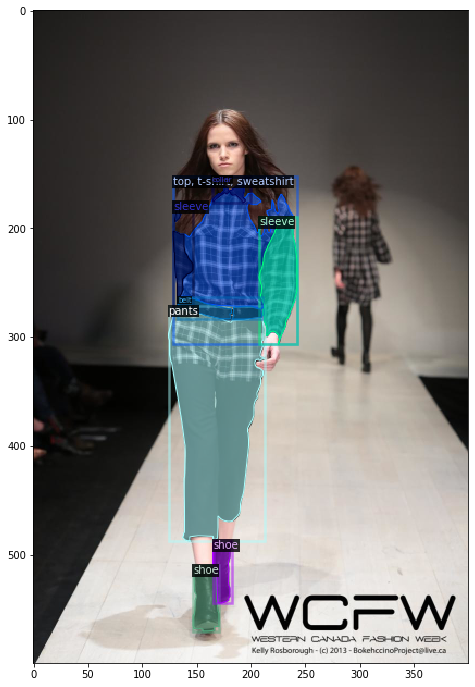

../imaterialist-fashion-2020-fgvc7/train/19ba7337ecc5b0f0b64098005e0910d2.jpg


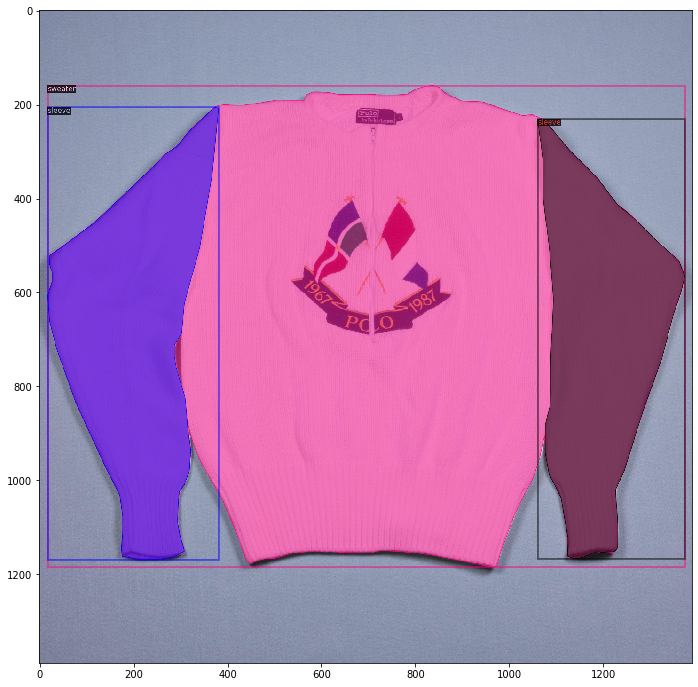

../imaterialist-fashion-2020-fgvc7/train/69fd48ce88dc915f4f966f93ddca0440.jpg


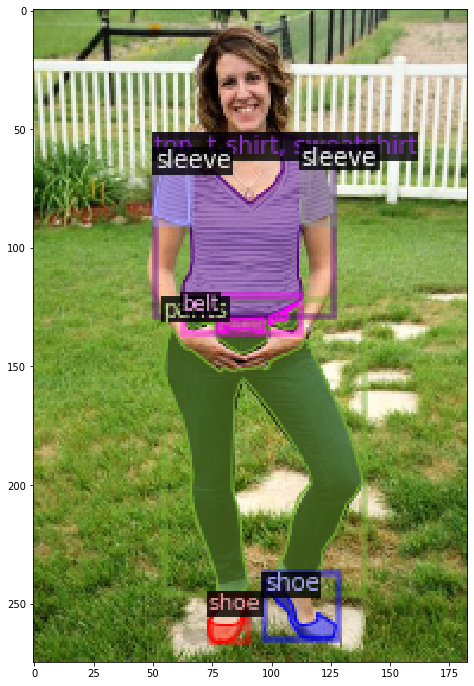

In [15]:
# let's have a look on prediction
test_dataset_dicts = DatasetCatalog.get(val_data_name)

for d in random.sample(test_dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Inference on Video

In [16]:
def inference_on_video(video_path, out_video_path):
    cap = cv2.VideoCapture(video_path)
    cnt = 0

    output_frames = []

    while True:
        ret, im = cap.read()

        if not ret:
            break

        if cnt%5 == 0:
            outputs = predictor(im)
            v = Visualizer(im[:, :, ::-1],
                           metadata=backpack_test_metadata, 
                           scale=0.8, 
#                            instance_mode=ColorMode.IMAGE_BW
                          )
            print(outputs)
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            output_frames.append(v.get_image()[:, :, ::-1])

        cnt = cnt + 1

    height, width, _ = output_frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, size)

    for i in range(len(output_frames)):
        out.write(output_frames[i])

    out.release()

In [21]:
#Output video is stored as out.mp4 with backpack segmentations

inference_on_video(os.path.join(data_dir, 'fashion_walk.mp4'), os.path.join(data_dir, 'fashion_walk_output.mp4'))

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[306.3808, 302.4307, 317.8271, 324.1163]], device='cuda:0')), scores: tensor([0.9328], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, 

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[305.6017, 307.9801, 317.4993, 329.8408]], device='cuda:0')), scores: tensor([0.9430], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[298.0451, 304.5647, 316.3754, 334.4203]], device='cuda:0')), scores: tensor([0.9423], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[319.1272, 154.4063, 332.0376, 234.2901],
        [297.1884, 318.5451, 310.4228, 345.0274],
        [306.4184, 309.7807, 321.2610, 334.7271]], device='cuda:0')), scores: tensor([0.9634, 0.9623, 0.9549], device='cuda:0'), pred_classes: tensor([31, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[285.0038, 305.9348, 305.2055, 346.3021],
        [250.2988, 141.1871, 281.4745, 236.3181],
        [317.9618, 143.4890, 331.4865, 228.7355]], device='cuda:0')), scores: tensor([0.9567, 0.9420, 0.9119], device='cuda:0'), pred_classes: tensor([23, 31, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[249.6396, 151.9745, 282.6429, 238.7569],
        [320.9226, 141.8538, 337.6754, 239.8128]], device='cuda:0')), scores: tensor([0.9381, 0.9367], device='cuda:0'), pred_classes: tensor([31, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[330.2190, 135.2364, 348.3885, 216.5944],
        [300.3424, 322.3559, 316.7474, 358.2401]], device='cuda:0')), scores: tensor([0.9727, 0.9666], device='cuda:0'), pred_classes: tensor([31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[256.2104, 114.8572, 293.0247, 216.6792],
        [309.6547, 309.7915, 332.6164, 350.8375]], device='cuda:0')), scores: tensor([0.9620, 0.9333], device='cuda:0'), pred_classes: tensor([31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[233.9130, 317.4615, 268.6111, 353.2925]], device='cuda:0')), scores: tensor([0.9823], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[234.4072, 316.1468, 267.3355, 354.0082],
        [169.2655, 107.5692, 207.5244, 215.6054]], device='cuda:0')), scores: tensor([0.9881, 0.9576], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[189.9833, 268.6213, 208.3985, 302.7726],
        [205.8306, 110.2883, 238.1499, 200.5121]], device='cuda:0')), scores: tensor([0.9537, 0.9311], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False, 

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[199.2385, 279.6530, 212.1592, 310.4449]], device='cuda:0')), scores: tensor([0.9242], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[190.4954, 288.1397, 208.4346, 319.2760]], device='cuda:0')), scores: tensor([0.9371], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[314.4275, 265.5865, 333.5667, 292.7821],
        [196.6693, 113.4807, 232.8270, 202.8890],
        [307.0037, 104.7238, 356.6234, 199.4643]], device='cuda:0')), scores: tensor([0.9510, 0.9430, 0.9427], device='cuda:0'), pred_classes: tensor([23, 31, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[321.9417, 285.5537, 334.5962, 321.9059],
        [296.9571, 104.7036, 356.4549, 217.9342],
        [198.2679, 110.8614, 234.0693, 192.4905],
        [150.2527, 113.8525, 166.5016, 193.1114]], device='cuda:0')), scores: tensor([0.9798, 0.9714, 0.9611, 0.9543], device='cuda:0'), pred_classes: tensor([23, 10, 31, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[289.2825,  97.9589, 371.3575, 224.0518],
        [322.2921, 306.1023, 338.4770, 340.8919],
        [183.9104, 249.2066, 201.3939, 280.6613]], device='cuda:0')), scores: tensor([0.9745, 0.9686, 0.9418], device='cuda:0'), pred_classes: tensor([10, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[320.7927, 301.4278, 337.7826, 342.6622],
        [291.0726,  88.4103, 363.0834, 217.9138]], device='cuda:0')), scores: tensor([0.9755, 0.9677], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[321.0014, 303.6869, 338.0750, 342.0708],
        [289.9857,  79.4177, 363.6041, 213.7547]], device='cuda:0')), scores: tensor([0.9841, 0.9773], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[296.5804,  79.2340, 361.5658, 210.5656],
        [325.1902, 302.6251, 340.7474, 339.6109],
        [308.5670, 126.1838, 354.1529, 135.4392]], device='cuda:0')), scores: tensor([0.9760, 0.9311, 0.9067], device='cuda:0'), pred_classes: tensor([10, 23, 19], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[296.3105,  93.1444, 361.3324, 219.0204],
        [321.2220, 309.7844, 338.1879, 349.4492]], device='cuda:0')), scores: tensor([0.9748, 0.9406], device='cuda:0'), pred_classes: tensor([10, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[364.2406, 314.4065, 395.5186, 351.7914],
        [357.2890, 108.1829, 410.2015, 230.9107]], device='cuda:0')), scores: tensor([0.9860, 0.9425], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[406.2393,  98.4539, 487.2304, 226.2224],
        [441.2558, 298.7719, 454.9902, 331.1459]], device='cuda:0')), scores: tensor([0.9513, 0.9458], device='cuda:0'), pred_classes: tensor([10, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[310.3323, 241.6620, 322.8961, 268.5121]], device='cuda:0')), scores: tensor([0.9176], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances'

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[316.1272, 283.0233, 329.8827, 316.0586],
        [284.5541, 102.1579, 300.9274, 163.1410],
        [307.3577, 267.8512, 322.3448, 298.9275]], device='cuda:0')), scores: tensor([0.9645, 0.9410, 0.9324], device='cuda:0'), pred_classes: tensor([23, 31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[245.8056, 310.9007, 276.9190, 345.9865],
        [190.7372,  95.8674, 238.8669, 185.2570]], device='cuda:0')), scores: tensor([0.9744, 0.9721], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[203.6172, 271.8947, 216.8968, 305.7280]], device='cuda:0')), scores: tensor([0.9762], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances'

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[231.4336, 272.9600, 245.0815, 303.2655]], device='cuda:0')), scores: tensor([0.9696], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[224.5554, 280.7339, 235.6314, 306.8851],
        [330.8618, 276.2372, 345.1107, 300.5782],
        [315.6666, 278.3275, 327.9788, 299.8433]], device='cuda:0')), scores: tensor([0.9415, 0.9280, 0.9222], device='cuda:0'), pred_classes: tensor([23, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[305.0283, 282.4025, 320.5150, 315.9480],
        [323.6935, 299.6678, 337.2607, 321.5887]], device='cuda:0')), scores: tensor([0.9409, 0.9351], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[303.1523, 298.7169, 318.1683, 327.0961],
        [321.4285, 276.9066, 334.4886, 311.8142]], device='cuda:0')), scores: tensor([0.9724, 0.9529], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[312.7509, 303.5758, 328.9272, 335.1065],
        [301.6076, 291.1918, 315.5974, 317.9278]], device='cuda:0')), scores: tensor([0.9504, 0.9139], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[294.7917, 301.7680, 312.5007, 328.6566]], device='cuda:0')), scores: tensor([0.9573], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[290.6674, 305.7954, 326.6063, 342.4649],
        [270.8413,  98.3889, 288.8170, 132.8940]], device='cuda:0')), scores: tensor([0.9747, 0.9178], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[386.8836, 297.4391, 426.3175, 338.7274],
        [393.0954, 191.2024, 458.9533, 306.6104],
        [441.1042, 299.9876, 458.7981, 325.3495]], device='cuda:0')), scores: tensor([0.9733, 0.9141, 0.9049], device='cuda:0'), pred_classes: tensor([23,  6, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[398.9359, 278.2336, 416.9924, 302.8757]], device='cuda:0')), scores: tensor([0.9332], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[431.4145, 277.8444, 446.8965, 316.5289]], device='cuda:0')), scores: tensor([0.9688], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[425.7717, 293.5513, 440.7920, 323.3706],
        [399.3348, 285.0766, 415.5125, 310.5229]], device='cuda:0')), scores: tensor([0.9487, 0.9031], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[412.2109, 289.8955, 427.7374, 334.8387],
        [426.1007, 310.7626, 440.7580, 334.5644]], device='cuda:0')), scores: tensor([0.9784, 0.9257], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[297.8388, 153.9165, 336.1918, 237.5617],
        [308.2374, 305.7608, 319.4976, 330.2991],
        [406.4940, 312.5378, 420.5434, 332.9526]], device='cuda:0')), scores: tensor([0.9102, 0.9085, 0.9023], device='cuda:0'), pred_classes: tensor([10, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[308.3374, 315.9964, 324.4676, 350.7781],
        [390.9891, 269.6982, 404.8801, 302.5336]], device='cuda:0')), scores: tensor([0.9309, 0.9289], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[303.8237, 289.7963, 320.8605, 325.9171],
        [316.0818, 306.6374, 332.0723, 340.1335]], device='cuda:0')), scores: tensor([0.9663, 0.9636], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[327.1854, 299.8774, 344.5305, 339.6958],
        [274.4602,  82.8787, 310.1008, 182.2343]], device='cuda:0')), scores: tensor([0.9864, 0.9359], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[327.0386, 303.4414, 346.8093, 346.8729],
        [275.1156,  77.1329, 310.8520, 179.3316]], device='cuda:0')), scores: tensor([0.9861, 0.9628], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[332.1250, 308.0342, 348.7285, 352.8197],
        [274.3337,  76.4819, 314.6125, 183.0339]], device='cuda:0')), scores: tensor([0.9751, 0.9610], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[331.0154, 306.3812, 351.1564, 345.5335],
        [280.3012,  73.6548, 319.7540, 177.4420]], device='cuda:0')), scores: tensor([0.9448, 0.9259], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[331.6432, 299.0401, 357.2159, 344.9007]], device='cuda:0')), scores: tensor([0.9777], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[331.5320, 297.8027, 355.2299, 338.1940],
        [255.0135, 298.7198, 292.1725, 337.0840]], device='cuda:0')), scores: tensor([0.9834, 0.9582], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[183.6797, 274.6402, 196.1466, 302.8214]], device='cuda:0')), scores: tensor([0.9312], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[316.6234, 225.2656, 326.0768, 247.8290]], device='cuda:0')), scores: tensor([0.9479], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[313.6211, 297.2150, 328.2475, 330.8644],
        [346.5849, 106.9085, 368.3523, 190.8115],
        [288.6067, 101.1634, 362.1392, 226.2476],
        [325.8831, 294.1233, 342.0446, 328.2302]], device='cuda:0')), scores: tensor([0.9737, 0.9422, 0.9345, 0.9033], device='cuda:0'), pred_classes: tensor([23, 31, 10, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[401.0648, 114.1608, 422.6007, 212.8005],
        [451.8650, 316.5229, 470.9717, 350.7868]], device='cuda:0')), scores: tensor([0.9384, 0.9071], device='cuda:0'), pred_classes: tensor([31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[461.3270, 294.3428, 474.7736, 326.5917]], device='cuda:0')), scores: tensor([0.9140], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[453.6775, 286.0564, 467.7396, 313.3491]], device='cuda:0')), scores: tensor([0.9307], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances'

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[330.3289, 286.5034, 344.4066, 316.2369],
        [437.0221, 256.7612, 449.7408, 287.1030]], device='cuda:0')), scores: tensor([0.9824, 0.9185], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[305.6559, 304.8316, 321.2773, 342.9524],
        [317.2086, 317.8810, 332.8792, 349.4849]], device='cuda:0')), scores: tensor([0.9735, 0.9559], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[322.6057, 315.9099, 337.3521, 354.2765]], device='cuda:0')), scores: tensor([0.9794], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[320.9321, 311.3015, 335.6815, 343.7802],
        [309.7682, 300.9504, 326.0437, 339.8988]], device='cuda:0')), scores: tensor([0.9555, 0.9492], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[237.8353, 312.0392, 274.1562, 346.1528]], device='cuda:0')), scores: tensor([0.9731], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[239.4834, 310.4257, 272.9626, 346.3417],
        [179.6950, 306.9766, 193.8156, 338.1958]], device='cuda:0')), scores: tensor([0.9724, 0.9131], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[340.2938, 276.5463, 356.3122, 292.6491]], device='cuda:0')), scores: tensor([0.9175], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, 

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[319.1362, 311.1725, 338.2164, 332.8705],
        [311.3480, 170.4670, 362.3352, 321.4257]], device='cuda:0')), scores: tensor([0.9597, 0.9163], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[298.8154, 156.0089, 345.7723, 336.1513]], device='cuda:0')), scores: tensor([0.9117], device='cuda:0'), pred_classes: tensor([10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[304.0896, 327.3813, 324.2445, 347.0512],
        [296.0111, 152.2670, 350.2027, 342.1675]], device='cuda:0')), scores: tensor([0.9605, 0.9106], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[304.6714, 326.6611, 322.3680, 352.7394],
        [286.2020, 128.8728, 342.4775, 343.8232]], device='cuda:0')), scores: tensor([0.9467, 0.9033], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[257.5579, 186.3799, 294.1021, 266.6548],
        [307.3552, 301.3815, 325.2515, 330.7054],
        [295.0679,  80.1207, 354.2243, 315.1743]], device='cuda:0')), scores: tensor([0.9671, 0.9426, 0.9164], device='cuda:0'), pred_classes: tensor([24, 23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[293.0064, 294.9274, 320.8355, 324.4835]], device='cuda:0')), scores: tensor([0.9097], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[313.7764, 316.8702, 328.3479, 333.6620],
        [287.1046,  75.6360, 352.9940, 325.2843]], device='cuda:0')), scores: tensor([0.9162, 0.9148], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[312.9419, 317.7875, 328.9775, 338.9888],
        [265.6730,  86.4966, 360.8572, 301.2318]], device='cuda:0')), scores: tensor([0.9610, 0.9283], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[239.9790, 201.5535, 287.7163, 278.7040],
        [280.2544,  85.4859, 338.9937, 338.6981],
        [283.4479, 323.0694, 301.0904, 350.4937]], device='cuda:0')), scores: tensor([0.9395, 0.9276, 0.9257], device='cuda:0'), pred_classes: tensor([24, 10, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[315.7224, 326.9483, 342.6303, 352.9382],
        [254.4522, 100.1723, 367.7759, 335.1423]], device='cuda:0')), scores: tensor([0.9628, 0.9005], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[306.8516, 245.7238, 320.2377, 286.6322]], device='cuda:0')), scores: tensor([0.9788], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[295.6704, 246.7088, 308.4828, 277.1494]], device='cuda:0')), scores: tensor([0.9050], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[320.9030, 311.1878, 334.7904, 347.7955],
        [337.5944, 299.8683, 353.3445, 341.9360]], device='cuda:0')), scores: tensor([0.9856, 0.9379], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[191.4143, 311.7060, 207.1159, 344.6920]], device='cuda:0')), scores: tensor([0.9264], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[188.6012, 317.7738, 204.6530, 352.1877],
        [166.5424, 301.2364, 185.7848, 343.9624]], device='cuda:0')), scores: tensor([0.9590, 0.9256], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[211.3543, 294.7501, 225.2988, 328.5700],
        [191.8956, 281.1856, 210.5806, 328.9738]], device='cuda:0')), scores: tensor([0.9781, 0.9595], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[335.1599, 222.4058, 347.8407, 246.2633],
        [215.5552, 304.9254, 232.0789, 341.7339]], device='cuda:0')), scores: tensor([0.9548, 0.9245], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[322.8404, 264.9805, 340.1672, 293.9599],
        [198.1856, 302.4003, 213.7922, 335.1771]], device='cuda:0')), scores: tensor([0.9755, 0.9609], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[333.2013, 282.4553, 354.4574, 314.4620],
        [206.3941, 283.9653, 220.3349, 312.4406]], device='cuda:0')), scores: tensor([0.9771, 0.9287], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[313.9205, 301.3856, 332.5695, 337.5366],
        [189.1898, 255.1174, 203.0224, 288.7892],
        [296.6791,  88.3521, 359.9555, 198.0605]], device='cuda:0')), scores: tensor([0.9859, 0.9596, 0.9500], device='cuda:0'), pred_classes: tensor([23, 23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[310.7238, 302.7475, 324.6536, 339.7748],
        [296.3248, 309.8164, 312.8206, 347.7303],
        [277.4857,  79.5681, 347.4132, 197.0123]], device='cuda:0')), scores: tensor([0.9673, 0.9650, 0.9293], device='cuda:0'), pred_classes: tensor([23, 23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[287.2986, 304.4705, 306.9294, 348.7685],
        [265.6202,  76.3105, 333.9609, 197.5052]], device='cuda:0')), scores: tensor([0.9802, 0.9525], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[315.0449, 293.3352, 334.6125, 337.3181],
        [301.3578, 303.7575, 317.3408, 342.2141]], device='cuda:0')), scores: tensor([0.9723, 0.9702], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[317.9507, 292.9287, 337.1435, 349.0759],
        [293.4769,  89.7601, 357.5239, 204.9462]], device='cuda:0')), scores: tensor([0.9596, 0.9419], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[323.4848, 313.2851, 349.2722, 352.4791],
        [295.6070, 290.7477, 316.9296, 334.6146]], device='cuda:0')), scores: tensor([0.9808, 0.9585], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[451.7408, 277.2795, 465.5621, 313.8586],
        [437.1504,  94.2300, 500.0129, 202.3048]], device='cuda:0')), scores: tensor([0.9266, 0.9218], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[440.8842, 266.3299, 459.9528, 303.4201]], device='cuda:0')), scores: tensor([0.9666], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[437.5699, 289.1094, 449.2957, 314.3653]], device='cuda:0')), scores: tensor([0.9332], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[437.8284, 285.0633, 449.3290, 315.1915],
        [427.5037, 281.4355, 439.1631, 305.8051]], device='cuda:0')), scores: tensor([0.9771, 0.9264], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[317.4506, 292.3434, 331.5399, 327.2312]], device='cuda:0')), scores: tensor([0.9715], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[322.0522, 297.1379, 336.1805, 334.1342]], device='cuda:0')), scores: tensor([0.9743], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[307.1566, 185.1614, 359.2953, 314.5556]], device='cuda:0')), scores: tensor([0.9455], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[309.6179, 187.4093, 361.3705, 317.4879],
        [325.6092, 319.0875, 341.8581, 359.2998]], device='cuda:0')), scores: tensor([0.9238, 0.9206], device='cuda:0'), pred_classes: tensor([ 6, 23], device='cuda:0'), pred_masks: tenso

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[337.2551, 311.2729, 354.7718, 352.6956],
        [319.8668, 301.6755, 338.2755, 345.5701],
        [315.7033, 156.1968, 375.0656, 303.3005]], device='cuda:0')), scores: tensor([0.9746, 0.9623, 0.9332], device='cuda:0'), pred_classes: tensor([23, 23,  6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[312.7895, 156.5240, 372.2419, 303.4327],
        [335.8408, 301.8724, 351.8886, 344.2799]], device='cuda:0')), scores: tensor([0.9349, 0.9143], device='cuda:0'), pred_classes: tensor([ 6, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[184.0430, 327.1906, 210.8399, 359.5298]], device='cuda:0')), scores: tensor([0.9288], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[202.4163, 254.8692, 214.7705, 282.7587]], device='cuda:0')), scores: tensor([0.9055], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, 

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[331.5290, 279.5500, 343.0385, 295.1721]], device='cuda:0')), scores: tensor([0.9200], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, 

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[472.0715, 131.0701, 546.3923, 356.7991]], device='cuda:0')), scores: tensor([0.9428], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[474.4197, 145.4548, 545.7214, 355.8907]], device='cuda:0')), scores: tensor([0.9700], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[477.0890, 295.4968, 490.5768, 332.6869],
        [436.9427, 152.2127, 496.5666, 323.3920]], device='cuda:0')), scores: tensor([0.9550, 0.9414], device='cuda:0'), pred_classes: tensor([23,  6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[295.4263, 242.4157, 308.8465, 273.1840]], device='cuda:0')), scores: tensor([0.9023], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[293.6354, 248.0501, 308.0560, 274.1034]], device='cuda:0')), scores: tensor([0.9364], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[297.3364, 274.2354, 310.9092, 311.6554],
        [263.3517, 101.3032, 346.0471, 208.7789]], device='cuda:0')), scores: tensor([0.9807, 0.9202], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.3200,  92.3962, 350.8945, 210.9629],
        [307.7486, 289.5573, 323.4112, 323.8322]], device='cuda:0')), scores: tensor([0.9706, 0.9704], device='cuda:0'), pred_classes: tensor([10, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[315.6452, 289.5249, 331.7046, 325.0090],
        [304.3039, 269.6944, 318.7327, 310.2247],
        [283.2078,  82.1438, 368.6928, 209.2451]], device='cuda:0')), scores: tensor([0.9749, 0.9625, 0.9415], device='cuda:0'), pred_classes: tensor([23, 23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[315.2850, 289.7062, 333.6741, 328.0306],
        [284.8531,  82.5452, 366.9301, 205.6077]], device='cuda:0')), scores: tensor([0.9840, 0.9413], device='cuda:0'), pred_classes: tensor([23, 10], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[341.5484, 303.8265, 356.8456, 344.3694],
        [290.0105,  97.7795, 383.2207, 217.4039],
        [363.7111, 106.7626, 382.3814, 140.3962]], device='cuda:0')), scores: tensor([0.9790, 0.9518, 0.9194], device='cuda:0'), pred_classes: tensor([23, 10, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[228.6807, 305.4486, 261.4251, 344.5546],
        [247.9583, 103.5888, 286.0721, 149.8655]], device='cuda:0')), scores: tensor([0.9728, 0.9268], device='cuda:0'), pred_classes: tensor([23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[187.1487, 285.5688, 202.1626, 323.0504]], device='cuda:0')), scores: tensor([0.9528], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[187.4289, 286.6815, 204.0453, 325.7265]], device='cuda:0')), scores: tensor([0.9390], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
       

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[210.0591, 116.7348, 227.5510, 142.7700],
        [154.1139, 115.9028, 172.7936, 143.6351],
        [179.6647, 292.5273, 196.1083, 325.1003]], device='cuda:0')), scores: tensor([0.9422, 0.9247, 0.9187], device='cuda:0'), pred_classes: tensor([31, 31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[318.6787, 266.1998, 331.3319, 278.6103],
        [168.1011, 296.1289, 182.9391, 331.4065]], device='cuda:0')), scores: tensor([0.9461, 0.9399], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[309.1115, 297.5821, 323.7415, 310.4517]], device='cuda:0')), scores: tensor([0.9658], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[309.9761, 296.5826, 335.7602, 310.6100],
        [179.8348, 255.5940, 193.1811, 285.6544]], device='cuda:0')), scores: tensor([0.9157, 0.9062], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[316.3729, 312.4328, 341.6709, 326.7906]], device='cuda:0')), scores: tensor([0.9134], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[294.9216, 147.6162, 364.0026, 313.7712],
        [313.9221, 317.3584, 330.1261, 335.2975],
        [346.6807, 145.3067, 381.6827, 195.9722]], device='cuda:0')), scores: tensor([0.9518, 0.9493, 0.9138], device='cuda:0'), pred_cl

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[302.7243, 302.6735, 318.3214, 322.3063],
        [318.8548, 304.0080, 333.4910, 318.8989]], device='cuda:0')), scores: tensor([0.9515, 0.9394], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[314.6949, 319.0035, 330.3955, 335.4885],
        [297.6925, 142.0020, 367.2401, 320.2007]], device='cuda:0')), scores: tensor([0.9679, 0.9115], device='cuda:0'), pred_classes: tensor([23,  6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fa

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[386.7094, 139.9878, 454.0780, 346.0895]], device='cuda:0')), scores: tensor([0.9629], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[380.9525, 136.5387, 459.8097, 325.5131],
        [438.8844, 309.0625, 458.2239, 336.6498]], device='cuda:0')), scores: tensor([0.9660, 0.9127], device='cuda:0'), pred_classes: tensor([ 6, 23], device='cuda:0'), pred_masks: tenso

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[297.7816, 180.9184, 347.3609, 299.8940]], device='cuda:0')), scores: tensor([0.9060], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances':

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[295.1643, 188.8774, 356.1142, 332.9767],
        [327.1183, 335.3749, 346.8516, 357.9098],
        [279.6687,  98.7946, 305.2153, 195.7704],
        [306.3717, 307.1566, 319.5921, 334.1540]], device='cuda:0')), scores: tensor([0.9558, 0.9498, 0.9385, 0.9211], device='cuda:0'), pred_classes: tensor([ 6, 23, 31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[288.6591, 177.7305, 352.8045, 328.3003],
        [319.6213, 322.4056, 339.3583, 345.3718],
        [293.3016, 305.3391, 309.3946, 335.9597],
        [276.8917,  82.6099, 299.9764, 171.6340]], device='cuda:0')), scores: tensor([0.9679, 0.9340, 0.9254, 0.9078], device='cuda:0'), pred_classes: tensor([ 6, 23, 23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[292.3817, 174.7059, 355.3909, 321.6020],
        [359.5029,  85.2265, 379.8012, 195.1407],
        [330.4200, 316.1766, 350.5536, 342.1963],
        [285.1502,  80.8822, 308.0122, 175.0688]], device='cuda:0')), scores: tensor([0.9763, 0.9627, 0.9430, 0.9379], device='cuda:0'), pred_classes: tensor([ 6, 31, 23, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=5, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[366.3026,  83.7389, 390.7434, 196.3504],
        [291.4037, 184.2536, 361.5202, 336.7922],
        [334.5418, 331.8430, 353.4263, 358.8088],
        [286.2893,  79.6062, 308.1852, 180.0172],
        [287.3459, 327.9933, 309.3546, 352.7729]], device='cuda:0')), scores: tensor([0.9706, 0.9659, 0.9556, 0.9308, 0.9082], device='cuda:0'), pred_classes: tensor([31,  6, 23, 31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, 

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[315.4729, 176.3478, 371.6008, 304.1614],
        [345.2209, 304.8326, 371.2191, 320.9886]], device='cuda:0')), scores: tensor([0.9463, 0.9082], device='cuda:0'), pred_classes: tensor([ 6, 23], device='cuda:0'), pred_masks: tensor([[[Fals

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[310.3651, 239.2887, 324.1356, 266.9503]], device='cuda:0')), scores: tensor([0.9481], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[313.0118, 282.9598, 324.5878, 301.3052]], device='cuda:0')), scores: tensor([0.9548], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, 

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[344.3105, 145.5608, 360.1563, 207.0512]], device='cuda:0')), scores: tensor([0.9089], device='cuda:0'), pred_classes: tensor([31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances'

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[302.6121, 317.3806, 319.5899, 335.6479],
        [326.8367, 292.0309, 340.7940, 326.0555],
        [276.2628, 103.1759, 298.7749, 184.9051],
        [341.6650,  95.7029, 361.2375, 191.3760]], device='cuda:0')), scores: tensor([0.9392, 0.9372, 0.9354, 0.9251], device='cuda:0'), pred_classes: tensor([23, 23, 31, 31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[347.8389,  84.3219, 368.1060, 190.9873],
        [277.3693,  85.6591, 301.0160, 174.1717],
        [335.0505, 309.1798, 352.6523, 334.1622],
        [309.9239, 315.9695, 328.6234, 334.2566]], device='cuda:0')), scores: tensor([0.9754, 0.9532, 0.9318, 0.9238], device='cuda:0'), pred_classes: tensor([31, 31, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[349.6914,  75.6599, 368.3825, 182.8627],
        [331.8409, 303.9785, 353.1878, 329.3063],
        [275.7557,  72.4058, 298.1900, 168.6939],
        [307.9090, 302.9372, 326.7379, 322.0568]], device='cuda:0')), scores: tensor([0.9705, 0.9302, 0.9127, 0.9032], device='cuda:0'), pred_classes: tensor([31, 23, 31, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[283.5191,  79.7858, 303.6654, 174.2681]], device='cuda:0')), scores: tensor([0.9474], device='cuda:0'), pred_classes: tensor([31], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[361.6104,  81.3397, 379.5799, 191.5083],
        [310.4713, 279.1145, 323.8976, 312.0470],
        [287.8911,  77.9428, 309.7669, 171.3635],
        [330.4461, 308.8409, 349.0869, 328.4813]], device='cuda:0')), scores: tensor([

{'instances': Instances(num_instances=5, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[288.9221,  80.5911, 312.4001, 177.0626],
        [304.3607, 175.1630, 364.1040, 309.4820],
        [360.5566,  88.8240, 376.0511, 198.4341],
        [332.3687, 312.6568, 352.3276, 333.4360],
        [314.9476, 285.8968, 331.3322, 313.9547]], device='cuda:0')), scores: tensor([0.9455, 0.9397, 0.9279, 0.9241, 0.9178], device='cuda:0'), pred_classes: tensor([31,  6, 31, 23, 23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, 

{'instances': Instances(num_instances=4, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[359.1183,  94.8874, 376.3772, 199.1103],
        [327.5272, 310.8112, 350.3647, 335.7823],
        [288.3008,  88.7826, 311.9014, 178.8828],
        [303.7862, 181.2033, 363.3158, 311.8615]], device='cuda:0')), scores: tensor([0.9785, 0.9546, 0.9516, 0.9450], device='cuda:0'), pred_classes: tensor([31, 23, 31,  6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, Fal

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[322.5203, 330.1730, 351.3122, 351.3547]], device='cuda:0')), scores: tensor([0.9144], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[239.3189, 162.0648, 349.6538, 336.8466]], device='cuda:0')), scores: tensor([0.9189], device='cuda:0'), pred_classes: tensor([6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
        

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[264.3615, 310.1146, 293.3482, 347.4895]], device='cuda:0')), scores: tensor([0.9806], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[189.3738, 315.3109, 219.2311, 349.7139],
        [264.4567, 306.6111, 292.8459, 348.2900]], device='cuda:0')), scores: tensor([0.9745, 0.9635], device='cuda:0'), pred_classes: tensor([23, 23], device='cuda:0'), pred_masks: tens

{'instances': Instances(num_instances=3, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[430.7353, 149.2001, 510.7435, 337.2755],
        [320.2785, 315.8678, 335.3996, 357.0388],
        [295.0198, 183.4169, 345.5674, 307.8111]], device='cuda:0')), scores: tensor([0.9750, 0.9722, 0.9202], device='cuda:0'), pred_classes: tensor([ 6, 23,  6], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False,

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance

{'instances': Instances(num_instances=1, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([[225.2066, 308.3075, 239.2178, 333.3147]], device='cuda:0')), scores: tensor([0.9246], device='cuda:0'), pred_classes: tensor([23], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances'

{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instances(num_instances=0, image_height=360, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 360, 640), dtype=torch.uint8)])}
{'instances': Instance